In [1]:
require(data.table)
require(dada2)
require(phyloseq)
require(DESeq2)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: dada2

Loading required package: Rcpp

Loading required package: phyloseq

Loading required package: DESeq2

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are ma

In [2]:
meta=fread("~/Documents/DE/DE_16S/DE16S_allmeta.csv")
asv_all=fread("~/Documents/DE/DE_16S/ASVs/Run123_ASV_nochim.csv")
taxa=read.csv("~/Documents/DE/DE_16S/ASVs/Run123_taxa.csv", header=TRUE, row.names=1)

In [3]:
#make RFTM presence absence
meta$RFTM_pa=ifelse(meta$RFTM_score=="0", 0, 1)
meta$RFTM_pa=factor(meta$RFTM_pa)

In [4]:
#fix rownames
rows=as.vector(asv_all[,1])
asv_all=asv_all[,-1]
asv_all=apply(asv_all, 2, as.numeric)
row.names(asv_all)=rows$V1

In [5]:
#pull out the dilution effect samples
meta_de=meta[meta$Experiment=="Field17"|meta$Experiment=="Lab18",]

In [6]:
meta_de17=meta[meta$Experiment=="Field17",]

In [7]:
asv_de17=asv_all[rownames(asv_all) %in% meta_de17$UniqueID,]

In [8]:
meta_de18=meta[meta$Experiment=="Lab18",]

In [9]:
asv_de18=asv_all[rownames(asv_all) %in% meta_de18$UniqueID,]

In [10]:
asv_de=asv_all[rownames(asv_all) %in% meta_de$UniqueID,]

In [11]:
dim(asv_de)

[1]   212 16383

In [23]:
asv_de=asv_de[rowSums(asv_de)>10000,]

In [24]:
dim(asv_de)

[1]   192 13376

In [25]:
asv_de=asv_de[,colSums(asv_de)>0]

In [26]:
dim(asv_de)

[1]   192 13250

In [27]:
#make taxa list that just applies to de samples
taxa_de=taxa[rownames(taxa)%in% colnames(asv_de),]

In [28]:
dim(taxa_de)

[1] 13250     6

In [29]:
#for some reason the bracket subsetting was having a hard time with the NAs
taxa_de_clean=subset(taxa_de, Kingdom!="Eukaryota")
taxa_de_clean=subset(taxa_de_clean, Order!="Chloroplast"|is.na(Order))

In [30]:
dim(taxa_de_clean)

[1] 12852     6

In [31]:
taxa_de_clean=as.matrix(taxa_de_clean)
meta_de=as.data.frame(meta_de)
row.names(meta_de)=meta_de$UniqueID

In [32]:
OTU = otu_table((asv_de), taxa_are_rows = FALSE)
TAX = tax_table(taxa_de_clean)
SAMP=sample_data(meta_de)

In [33]:
SAMP$Species=gsub("MM", "AM", SAMP$Species)

In [34]:
DE = phyloseq(OTU, TAX, SAMP)

In [35]:
DE

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12852 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 18 sample variables ]
tax_table()   Taxonomy Table:    [ 12852 taxa by 6 taxonomic ranks ]

In [36]:
DE17=subset_samples(DE, Year=="2017")
DE17=prune_taxa(taxa_sums(DE17)>0, DE17)


DE18=subset_samples(DE, Year=="2018")
DE18=prune_taxa(taxa_sums(DE18)>0, DE18)

In [37]:
DE18CV=subset_samples(DE18, Species=="CV")
DE18CV=prune_taxa(taxa_sums(DE18CV)>0, DE18CV)

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


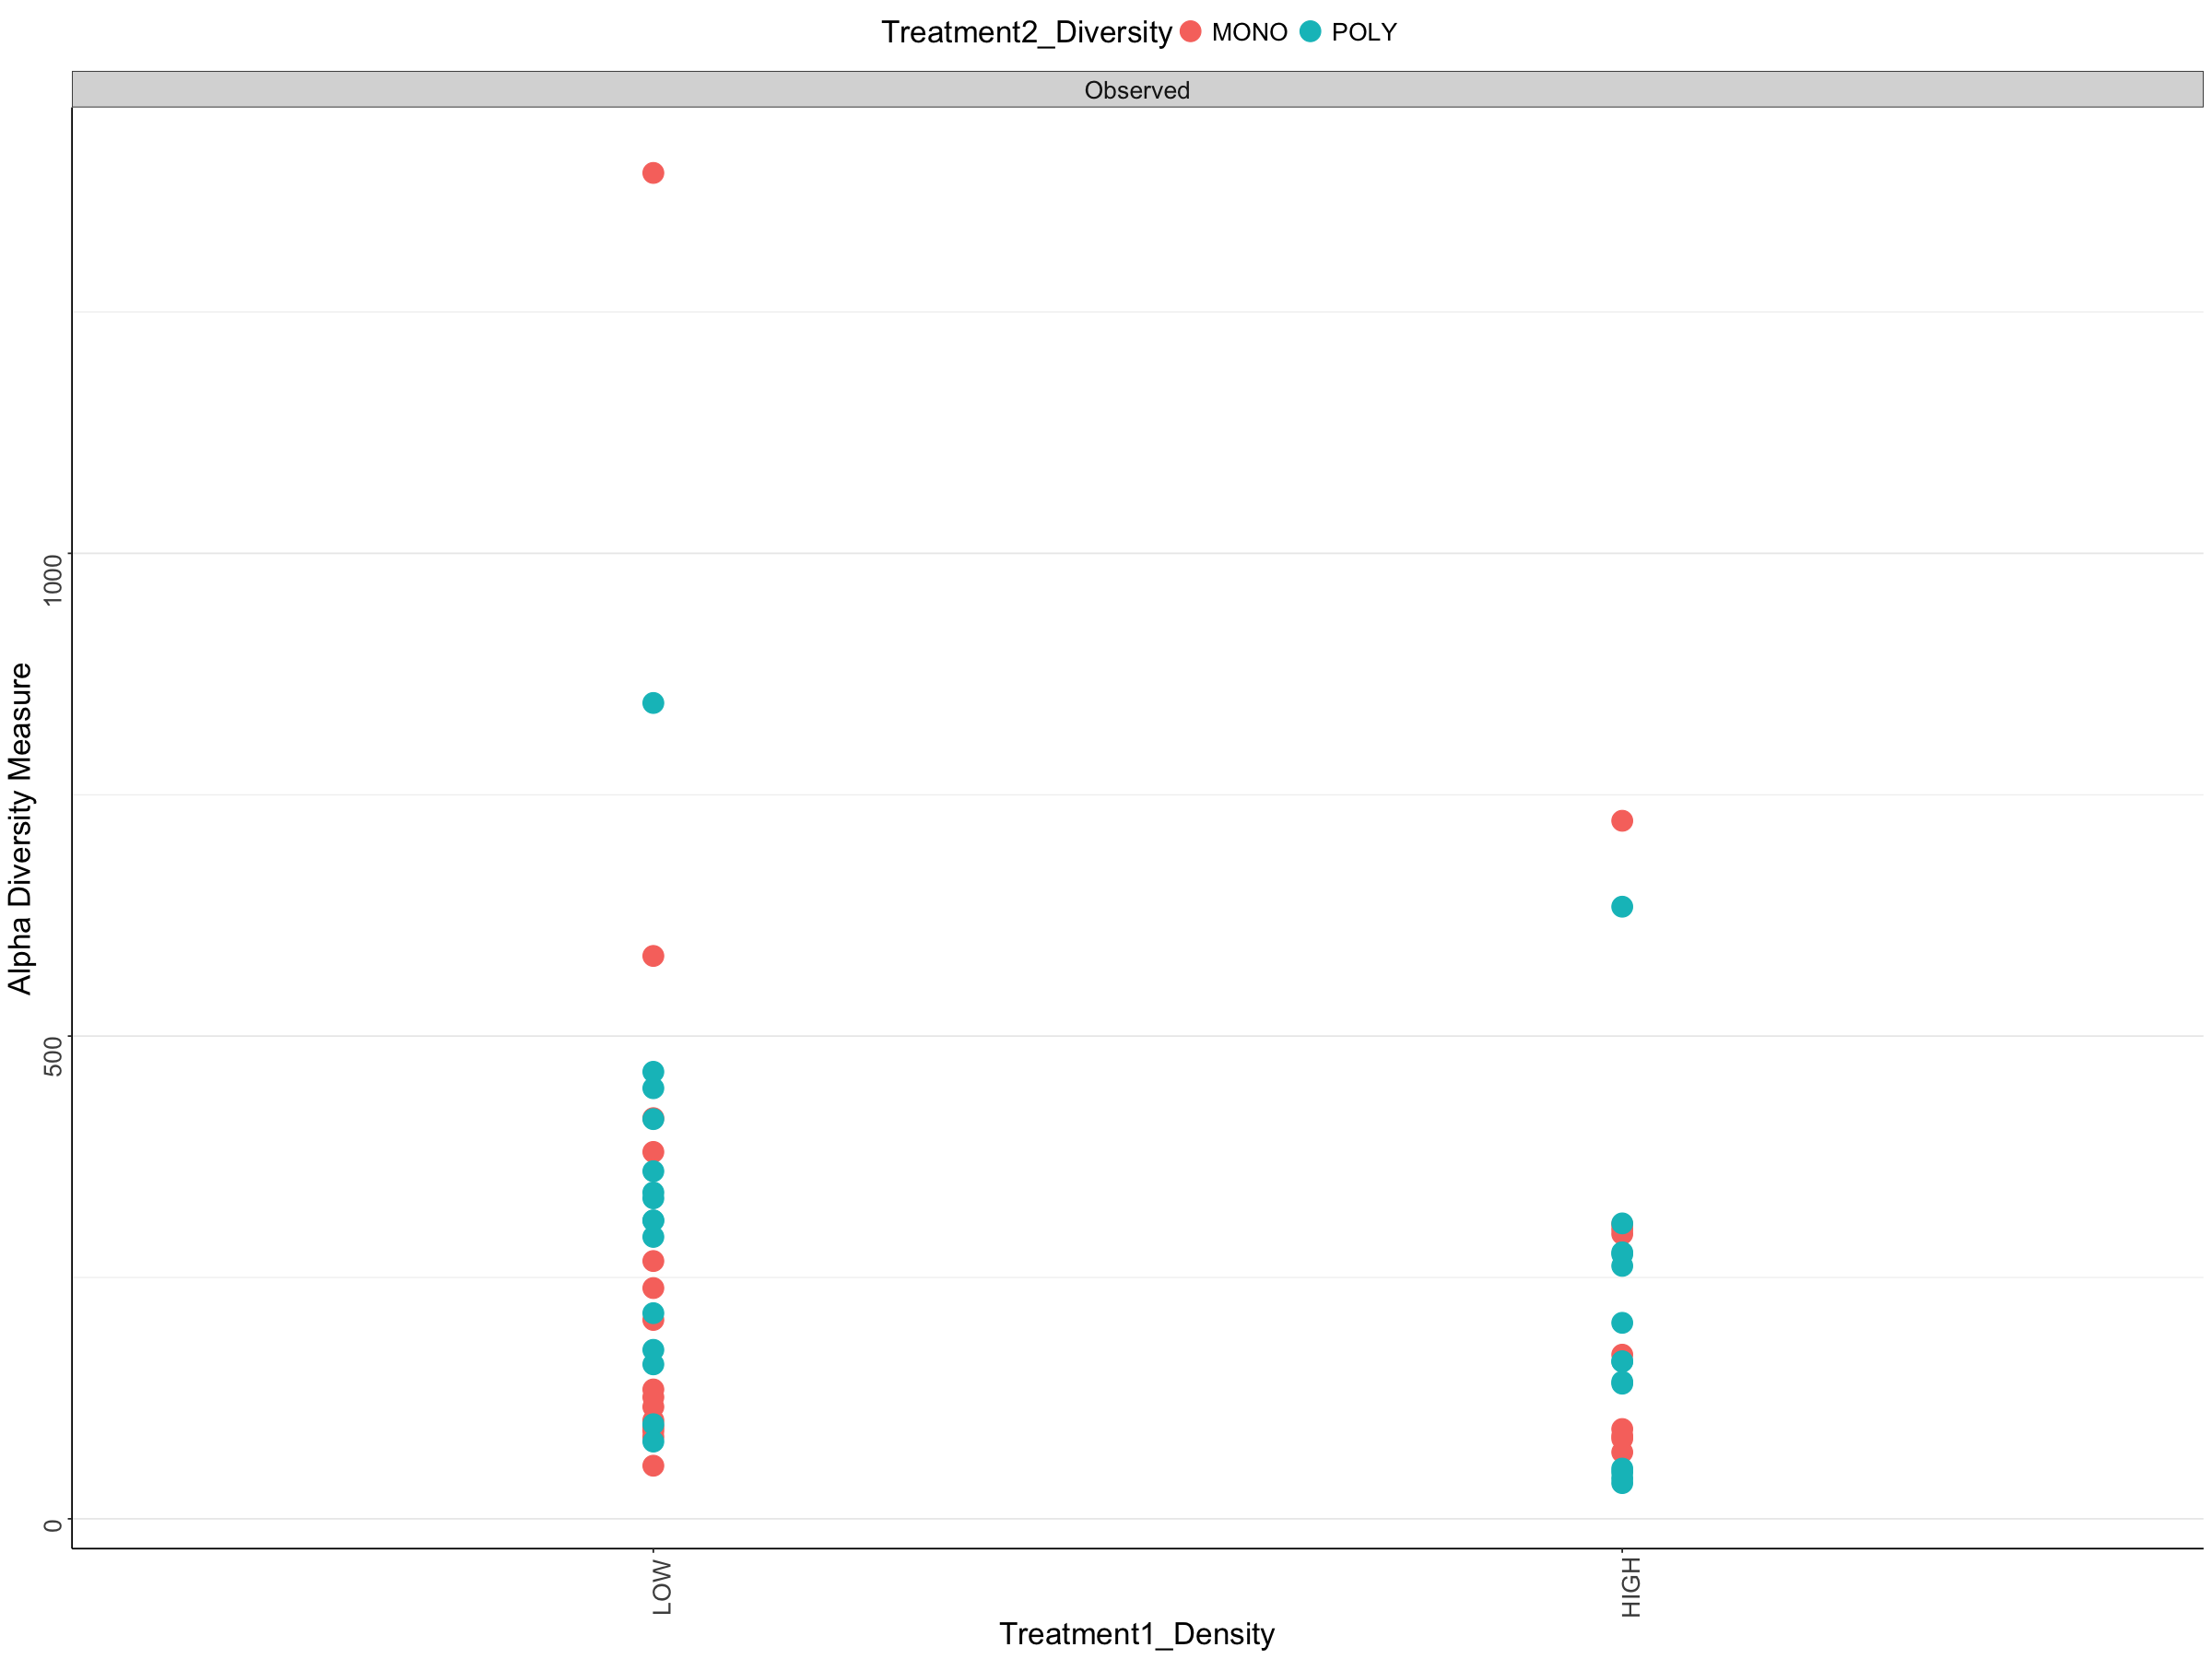

In [38]:
plot_richness(DE18CV, color="Treatment2_Diversity", x="Treatment1_Density", measures= "Observed")+
geom_point(size=6)+
#geom_vline(xintercept = 16)+
theme_bw()+
scale_x_discrete(limits = rev)+
theme(legend.position="top", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.line=element_line(color="black"), axis.text=element_text(angle=90),
          text = element_text(size=20))

In [39]:
mycolors= colorRampPalette(brewer.pal(8, "Accent"))(4)

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


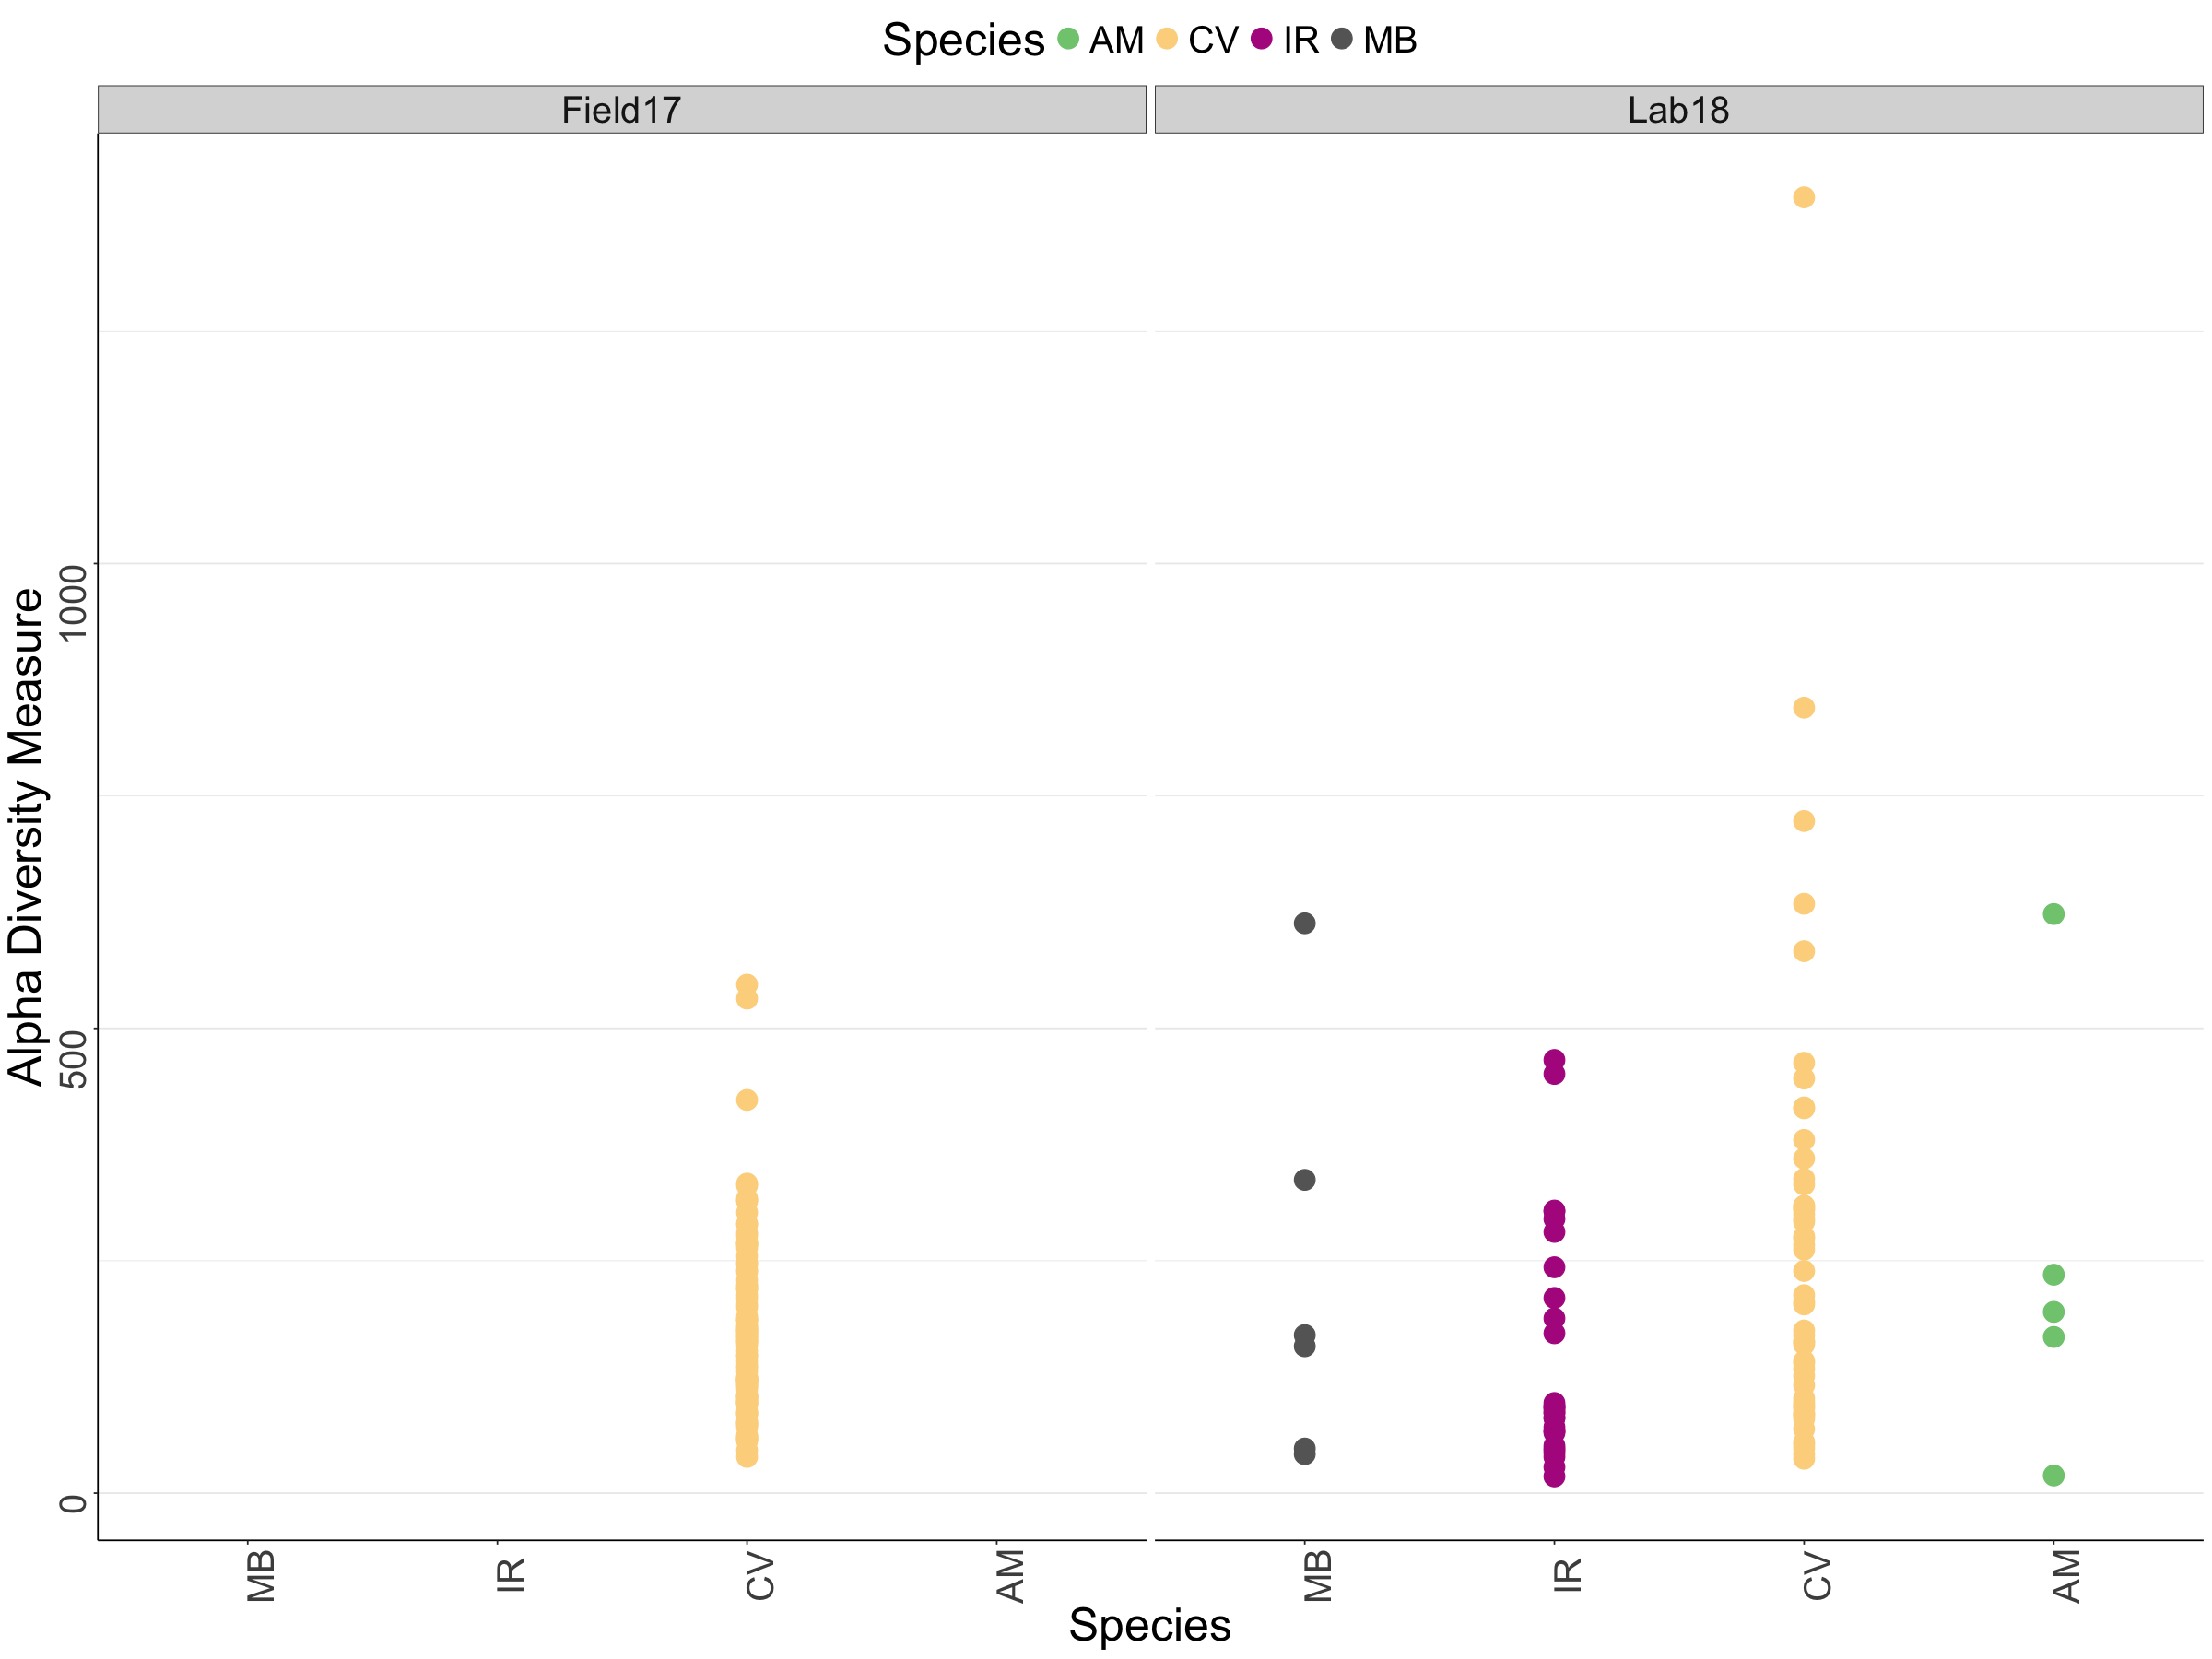

In [40]:
plot_richness(DE, color="Species", x="Species", measures= c( "Observed"))+
geom_point(size=6)+
#geom_vline(xintercept = 16)+
theme_bw()+
scale_color_manual(values=mycolors)+
facet_grid(.~Experiment)+
scale_x_discrete(limits = rev)+
theme(legend.position="top", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.line=element_line(color="black"), axis.text=element_text(angle=90),
          text = element_text(size=30))

In [41]:
ggsave(file="~/Documents/DE/Figures/Richness_all.pdf", width = 15, height=10)

In [42]:
DE18.dist=phyloseq::distance(DE18, "bray", type="samples")
DE18CV.dist=phyloseq::distance(DE18CV, "bray", type="samples")
DE17.dist=phyloseq::distance(DE17, "bray", type="samples")


In [43]:
DE.dist=phyloseq::distance(DE, "bray", type="samples")


In [44]:
sampledf=as.data.frame(sample_data(DE))


In [45]:
bd.Species=betadisper(DE.dist, sampledf$Species)

In [46]:
permutest(bd.Species)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq  Mean Sq     F N.Perm Pr(>F)    
Groups      3 0.5434 0.181139 8.407    999  0.001 ***
Residuals 188 4.0507 0.021546                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [47]:
bd.Species


	Homogeneity of multivariate dispersions

Call: betadisper(d = DE.dist, group = sampledf$Species)

No. of Positive Eigenvalues: 139
No. of Negative Eigenvalues: 52

Average distance to median:
    AM     CV     IR     MB 
0.5416 0.5400 0.3948 0.4702 

Eigenvalues for PCoA axes:
(Showing 8 of 191 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
15.319  6.942  5.669  4.635  2.545  1.995  1.914  1.524 

In [49]:
pdf(width=20, height=10, file="~/Documents/DE/Figures/Dispersion.pdf")
boxplot(bd.Species)
dev.off()

pdf 
  2

In [37]:
dev.off()

null device 
          1

In [50]:
TukeyHSD(bd.Species)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
              diff         lwr         upr     p adj
CV-AM -0.001607122 -0.17456331  0.17134906 0.9999950
IR-AM -0.146811365 -0.33060720  0.03698447 0.1665916
MB-AM -0.071396413 -0.30179669  0.15900386 0.8528334
IR-CV -0.145204243 -0.22126094 -0.06914755 0.0000098
MB-CV -0.069789291 -0.22818120  0.08860262 0.6639396
MB-IR  0.075414952 -0.09474693  0.24557683 0.6597639


In [24]:
bd.Species=betadisper(DE18.dist, sampledf$Species)
bd.Bucket=betadisper(DE18.dist, sampledf$Color_Bucket)

In [25]:
anova(bd.Species)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.403141,0.13438033,4.841969,0.003510159
Residuals,96,2.664311,0.02775324,NA,NA


In [26]:
permutest(bd.Species)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df  Sum Sq  Mean Sq     F N.Perm Pr(>F)   
Groups     3 0.40314 0.134380 4.842    999  0.003 **
Residuals 96 2.66431 0.027753                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [27]:
TukeyHSD(bd.Species)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
             diff         lwr         upr     p adj
IR-CV -0.13468563 -0.23264138 -0.03672988 0.0028499
MB-CV -0.06491591 -0.25171019  0.12187837 0.8002775
MM-CV  0.03960876 -0.14718552  0.22640304 0.9451364
MB-IR  0.06976972 -0.12502546  0.26456491 0.7853288
MM-IR  0.17429439 -0.02050079  0.36908958 0.0963240
MM-MB  0.10452467 -0.14695483  0.35600417 0.6984577


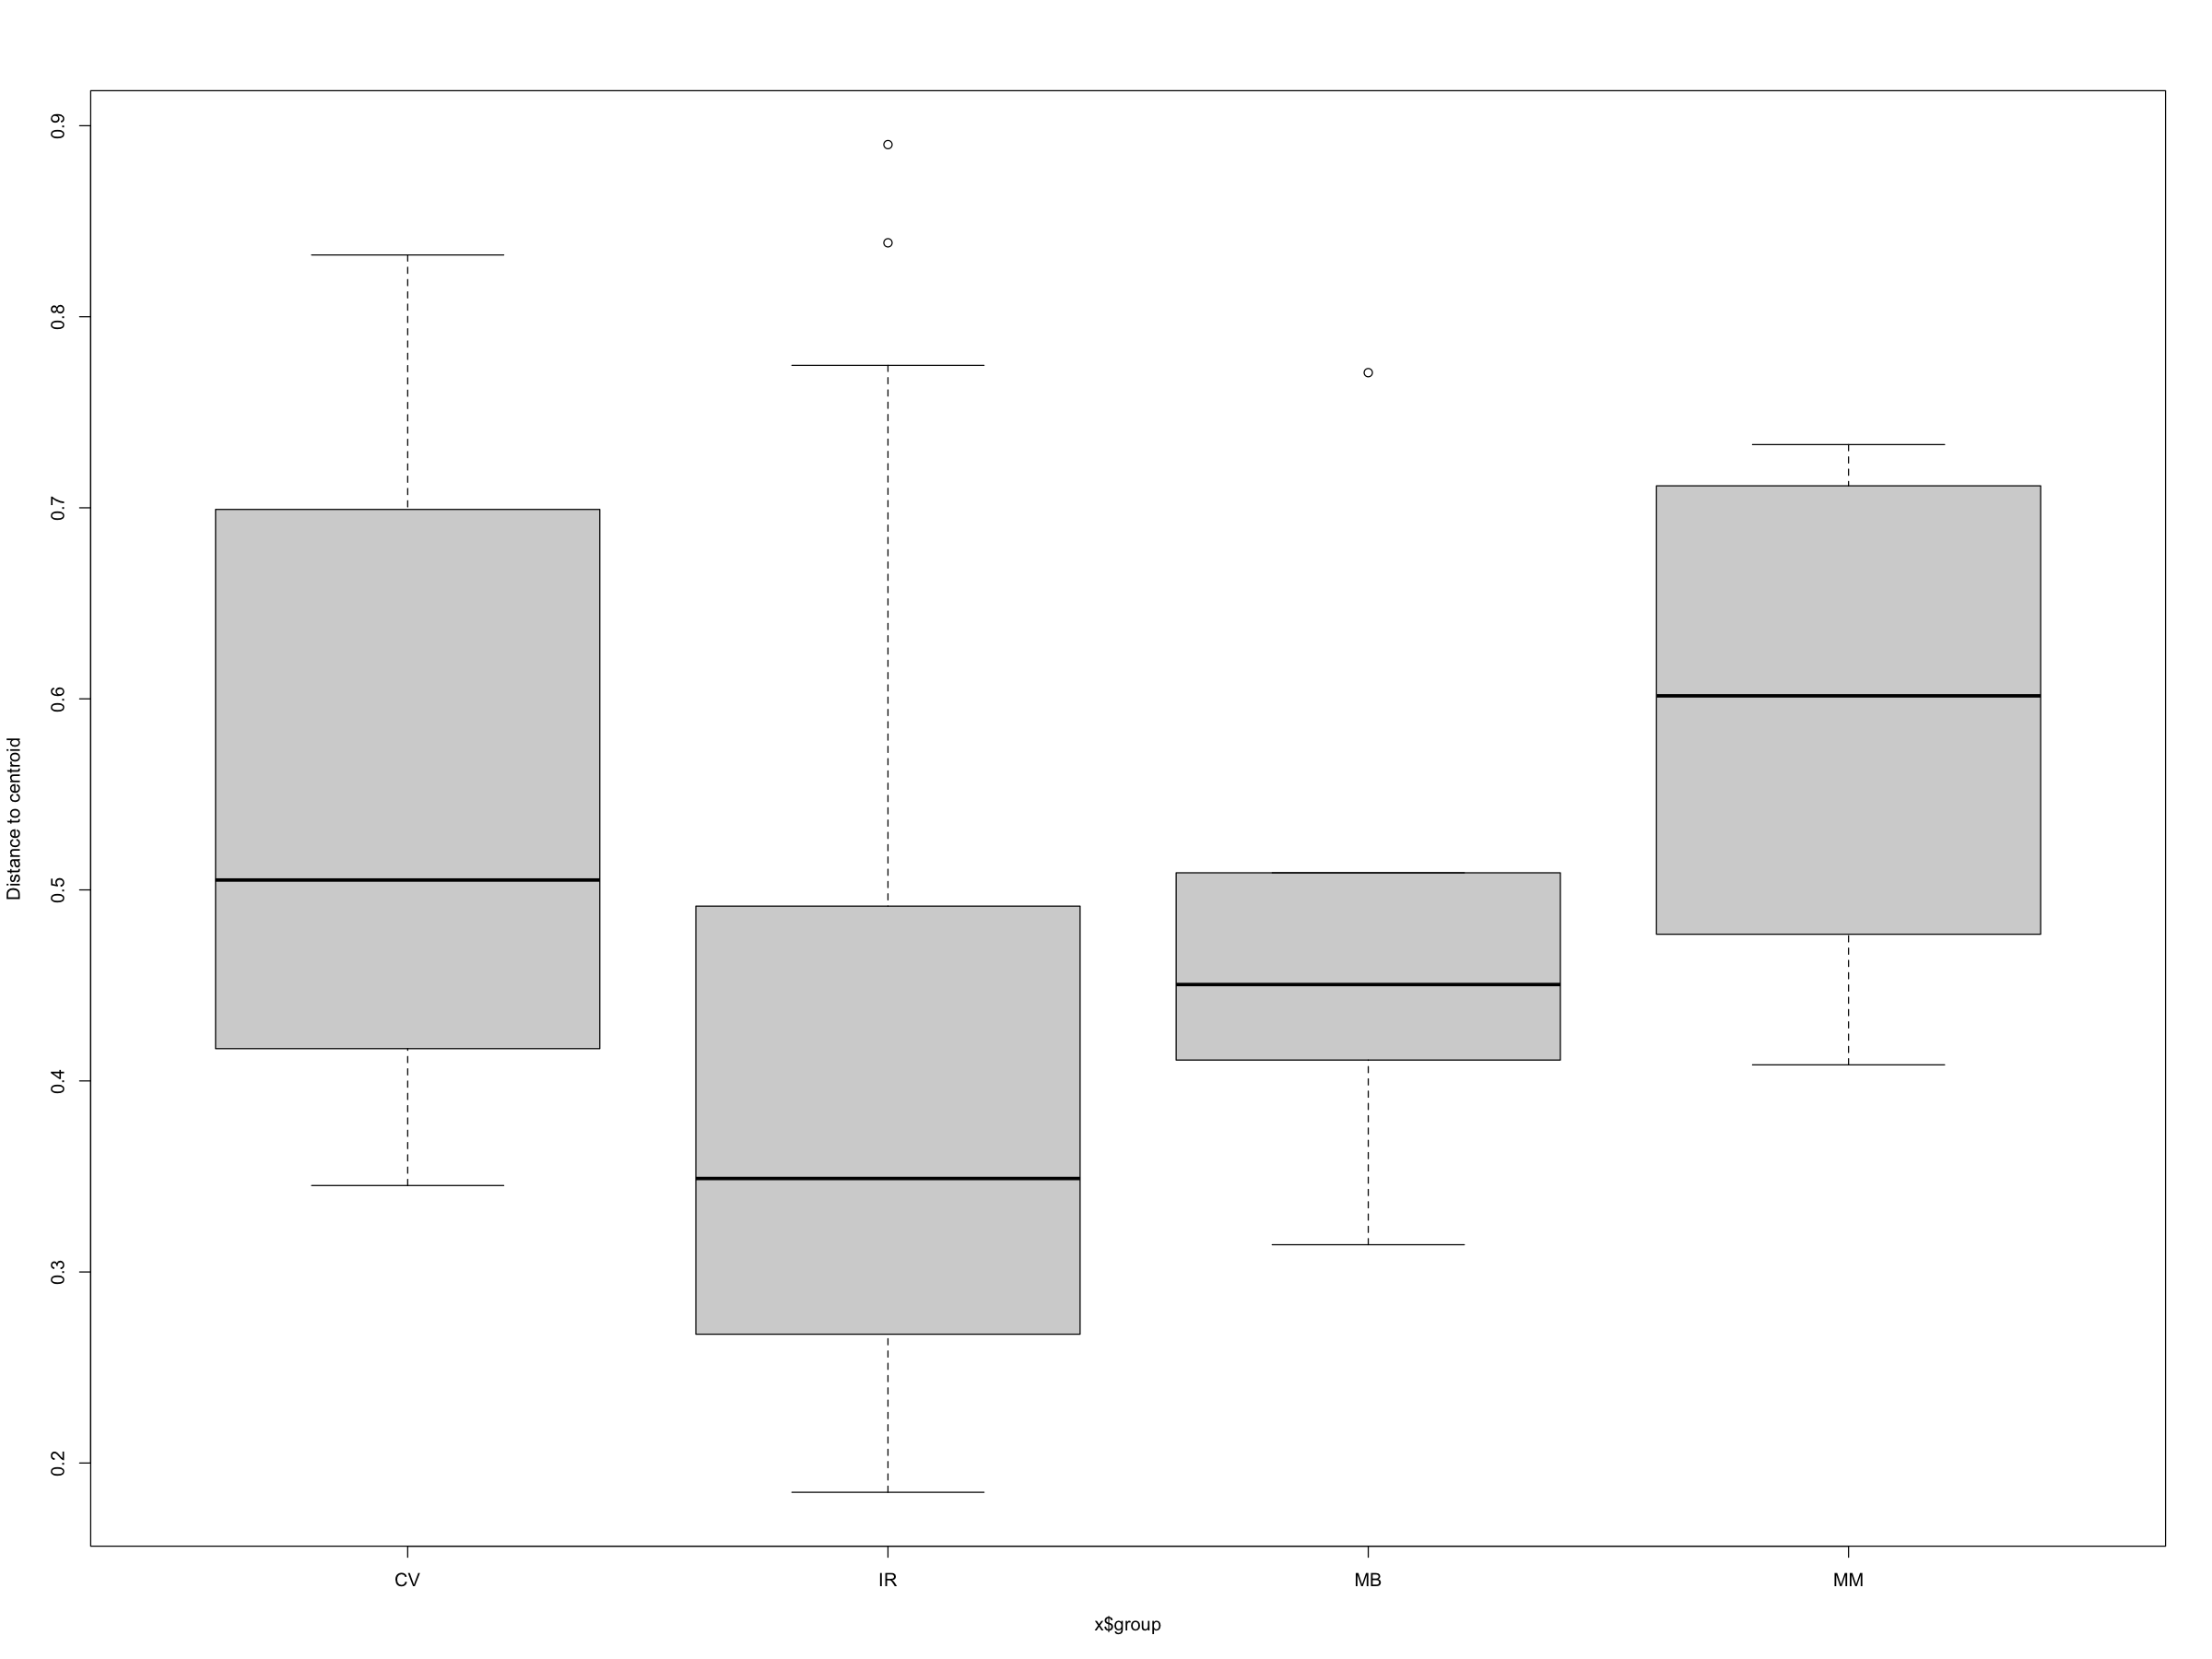

In [28]:
boxplot(bd.Species)

In [90]:
sampledf=as.data.frame(sample_data(DE18CV))


In [89]:
sample_data(DE18)

,V1,UniqueID,Experiment,Year,Site,Treatment1_Density,Treatment2_Diversity,Color_Bucket,Number,Species,RFTM_score,peacrabs,Phase_1_DO,Phase_1_temp,Phase_2_DO,Phase_2_Temp,Overall_treatment,RFTM_pa
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
2018__HIGH_MONO_HM1O73_CV,116,2018__HIGH_MONO_HM1O73_CV,Lab18,2018,,HIGH,MONO,HM1,O73,CV,0.0,0,,,,,,0
2018__HIGH_MONO_HM1W15_CV,113,2018__HIGH_MONO_HM1W15_CV,Lab18,2018,,HIGH,MONO,HM1,W15,CV,0.0,0,,,,,,0
2018__HIGH_MONO_HM1W33_CV,114,2018__HIGH_MONO_HM1W33_CV,Lab18,2018,,HIGH,MONO,HM1,W33,CV,0.0,0,,,,,,0
2018__HIGH_MONO_HM1W96_CV,115,2018__HIGH_MONO_HM1W96_CV,Lab18,2018,,HIGH,MONO,HM1,W96,CV,0.0,0,,,,,,0
2018__HIGH_MONO_HM4Y44_CV,121,2018__HIGH_MONO_HM4Y44_CV,Lab18,2018,,HIGH,MONO,HM4,Y44,CV,0.0,NA,,,,,,0
2018__HIGH_MONO_HM4Y53_CV,122,2018__HIGH_MONO_HM4Y53_CV,Lab18,2018,,HIGH,MONO,HM4,Y53,CV,0.0,NA,,,,,,0
2018__HIGH_MONO_HM8O20_CV,123,2018__HIGH_MONO_HM8O20_CV,Lab18,2018,,HIGH,MONO,HM8,O20,CV,0.0,NA,,,,,,0
2018__HIGH_MONO_HM8O34_CV,124,2018__HIGH_MONO_HM8O34_CV,Lab18,2018,,HIGH,MONO,HM8,O34,CV,0.0,NA,,,,,,0
2018__HIGH_MONO_HM8O66_CV,125,2018__HIGH_MONO_HM8O66_CV,Lab18,2018,,HIGH,MONO,HM8,O66,CV,0.0,NA,,,,,,0


In [91]:
bd.Treatment1_Density=betadisper(DE18CV.dist, sampledf$Treatment1_Density)
bd.Treatment2_Diversity=betadisper(DE18CV.dist, sampledf$Treatment2_Diversity)


In [97]:
sampledf=as.data.frame(sample_data(DE17))


In [103]:
bd.RFTM_pa=betadisper(DE17.dist, sampledf$RFTM_pa)
bd.RFTM_peacrab=betadisper(DE17.dist, sampledf$peacrabs)

In [104]:
permutest(bd.RFTM_peacrab)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq   Mean Sq      F N.Perm Pr(>F)
Groups      1 0.00074 0.0007444 0.0582    999  0.809
Residuals 110 1.40570 0.0127791                     

In [99]:
permutest(bd.RFTM_pa)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq  Mean Sq      F N.Perm Pr(>F)
Groups      1 0.02247 0.022468 1.7777    999  0.189
Residuals 110 1.39031 0.012639                     

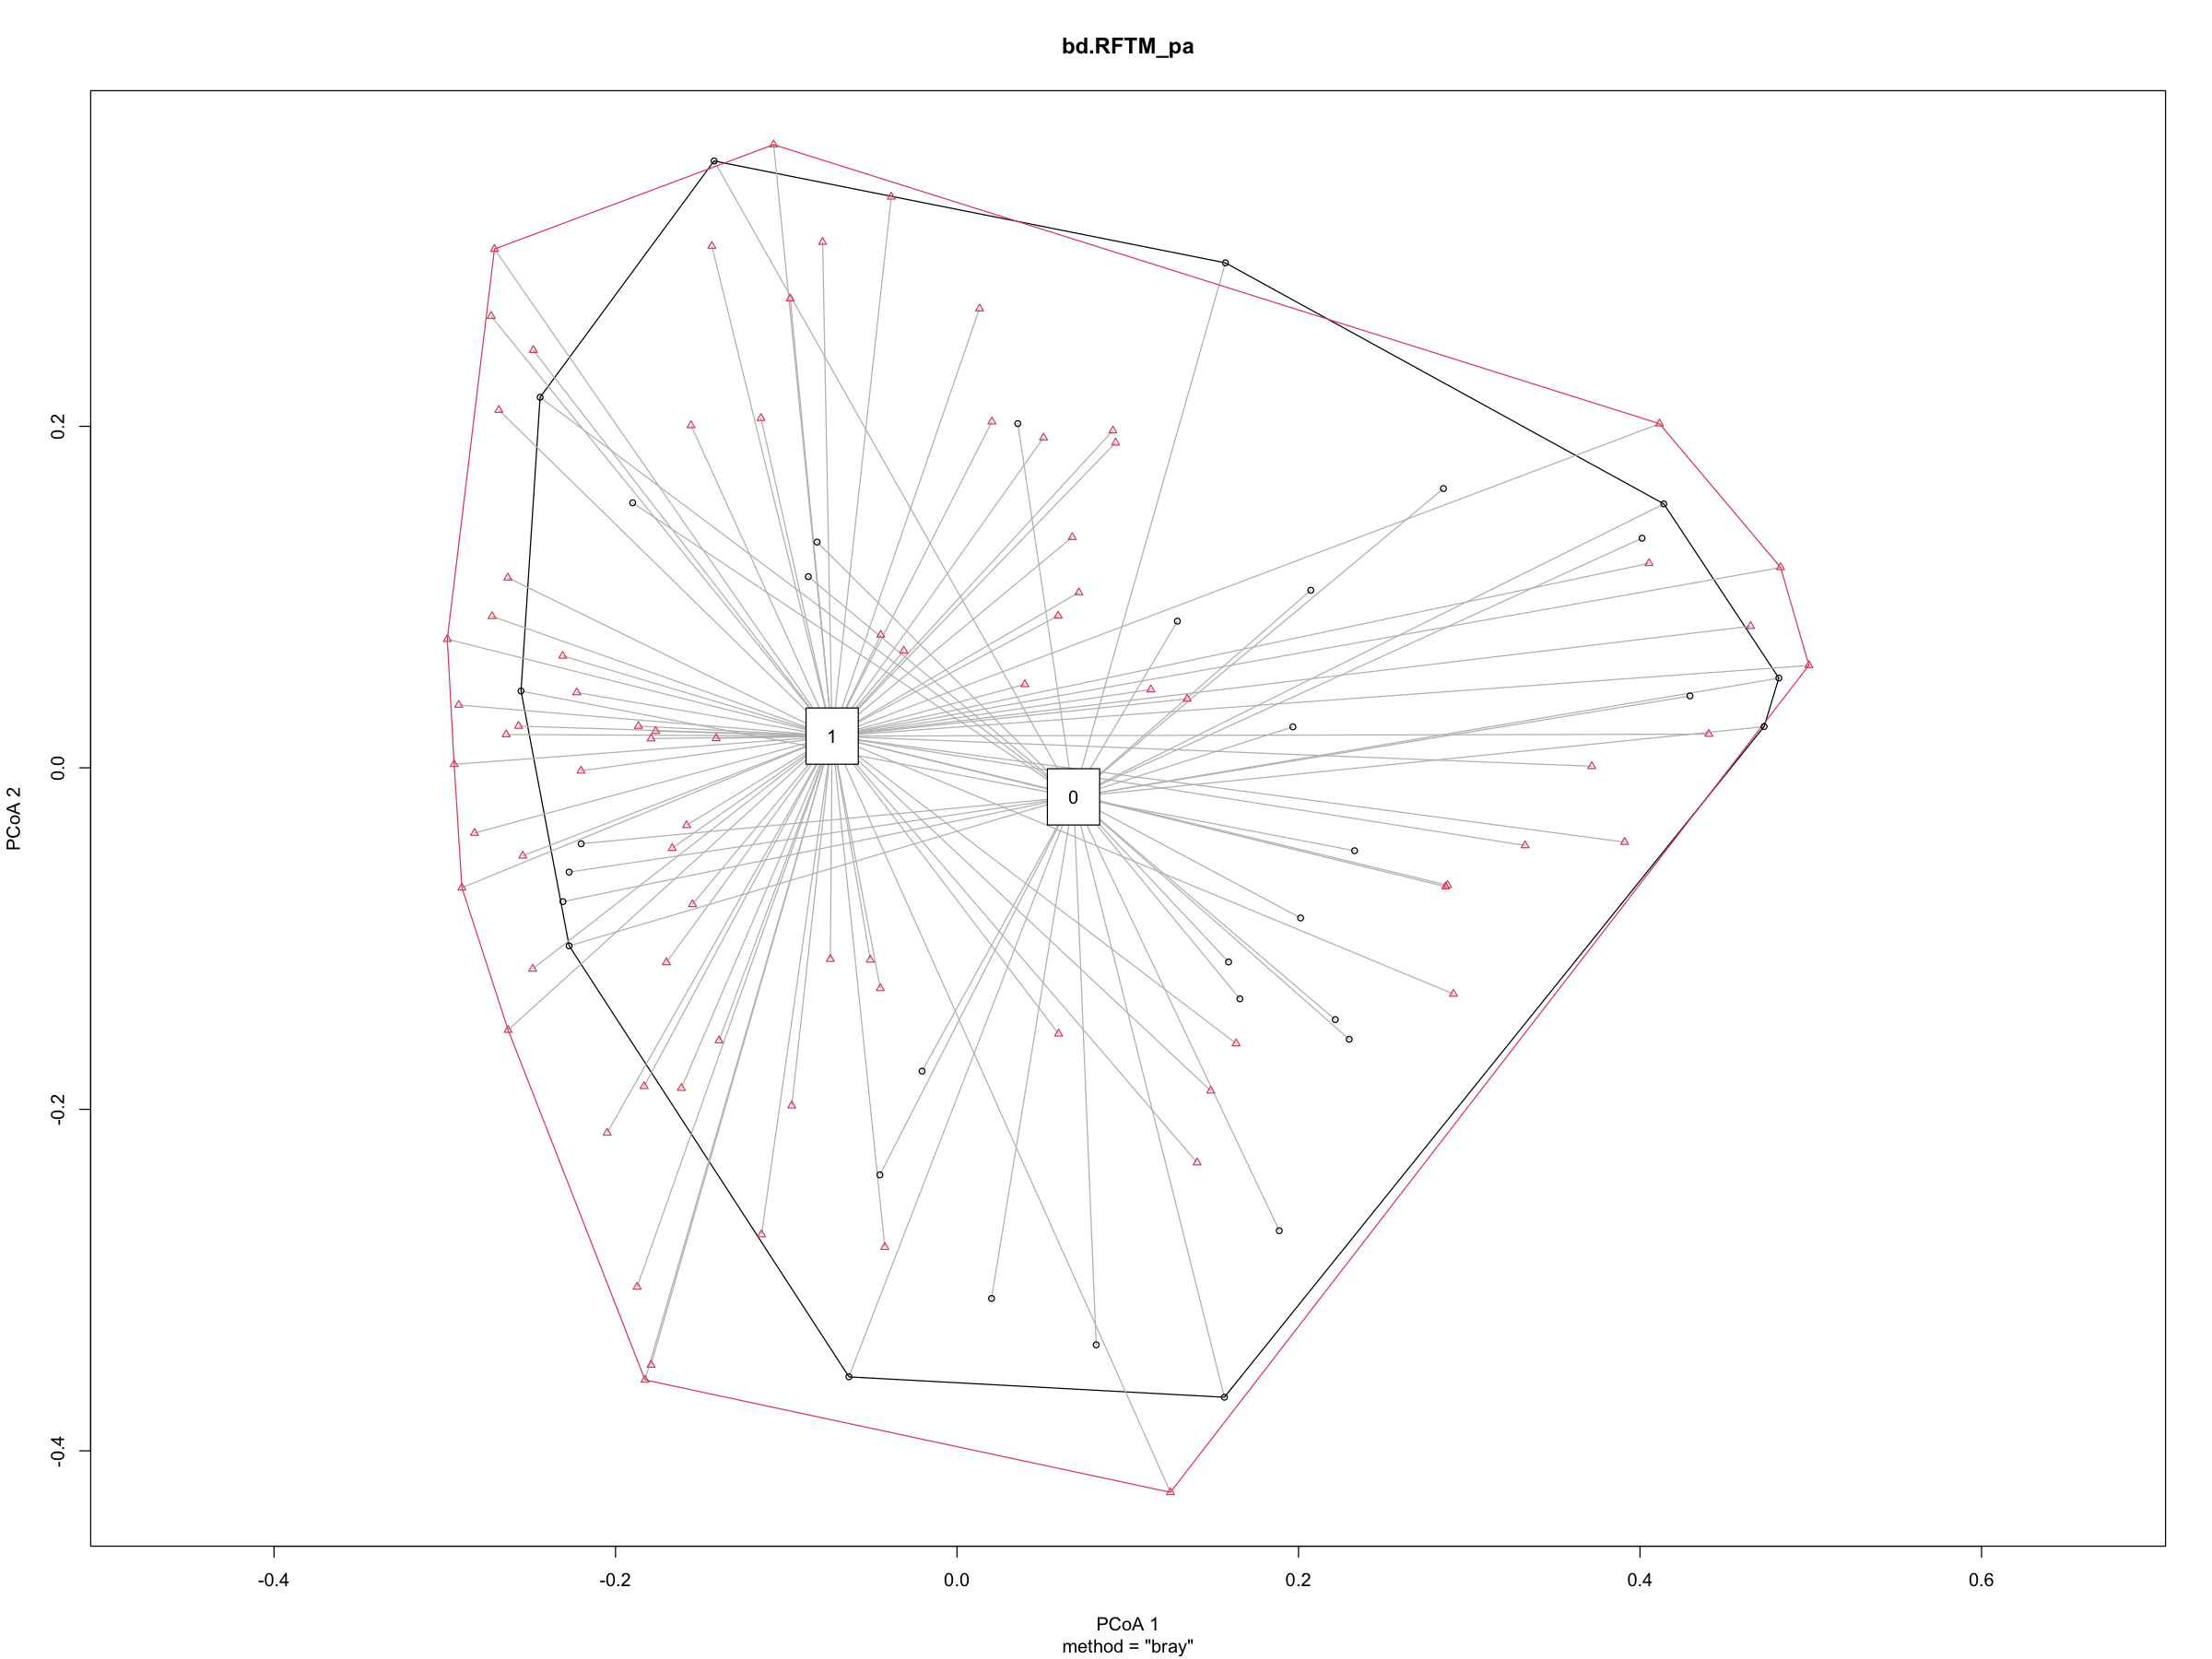

In [100]:
plot(bd.RFTM_pa)

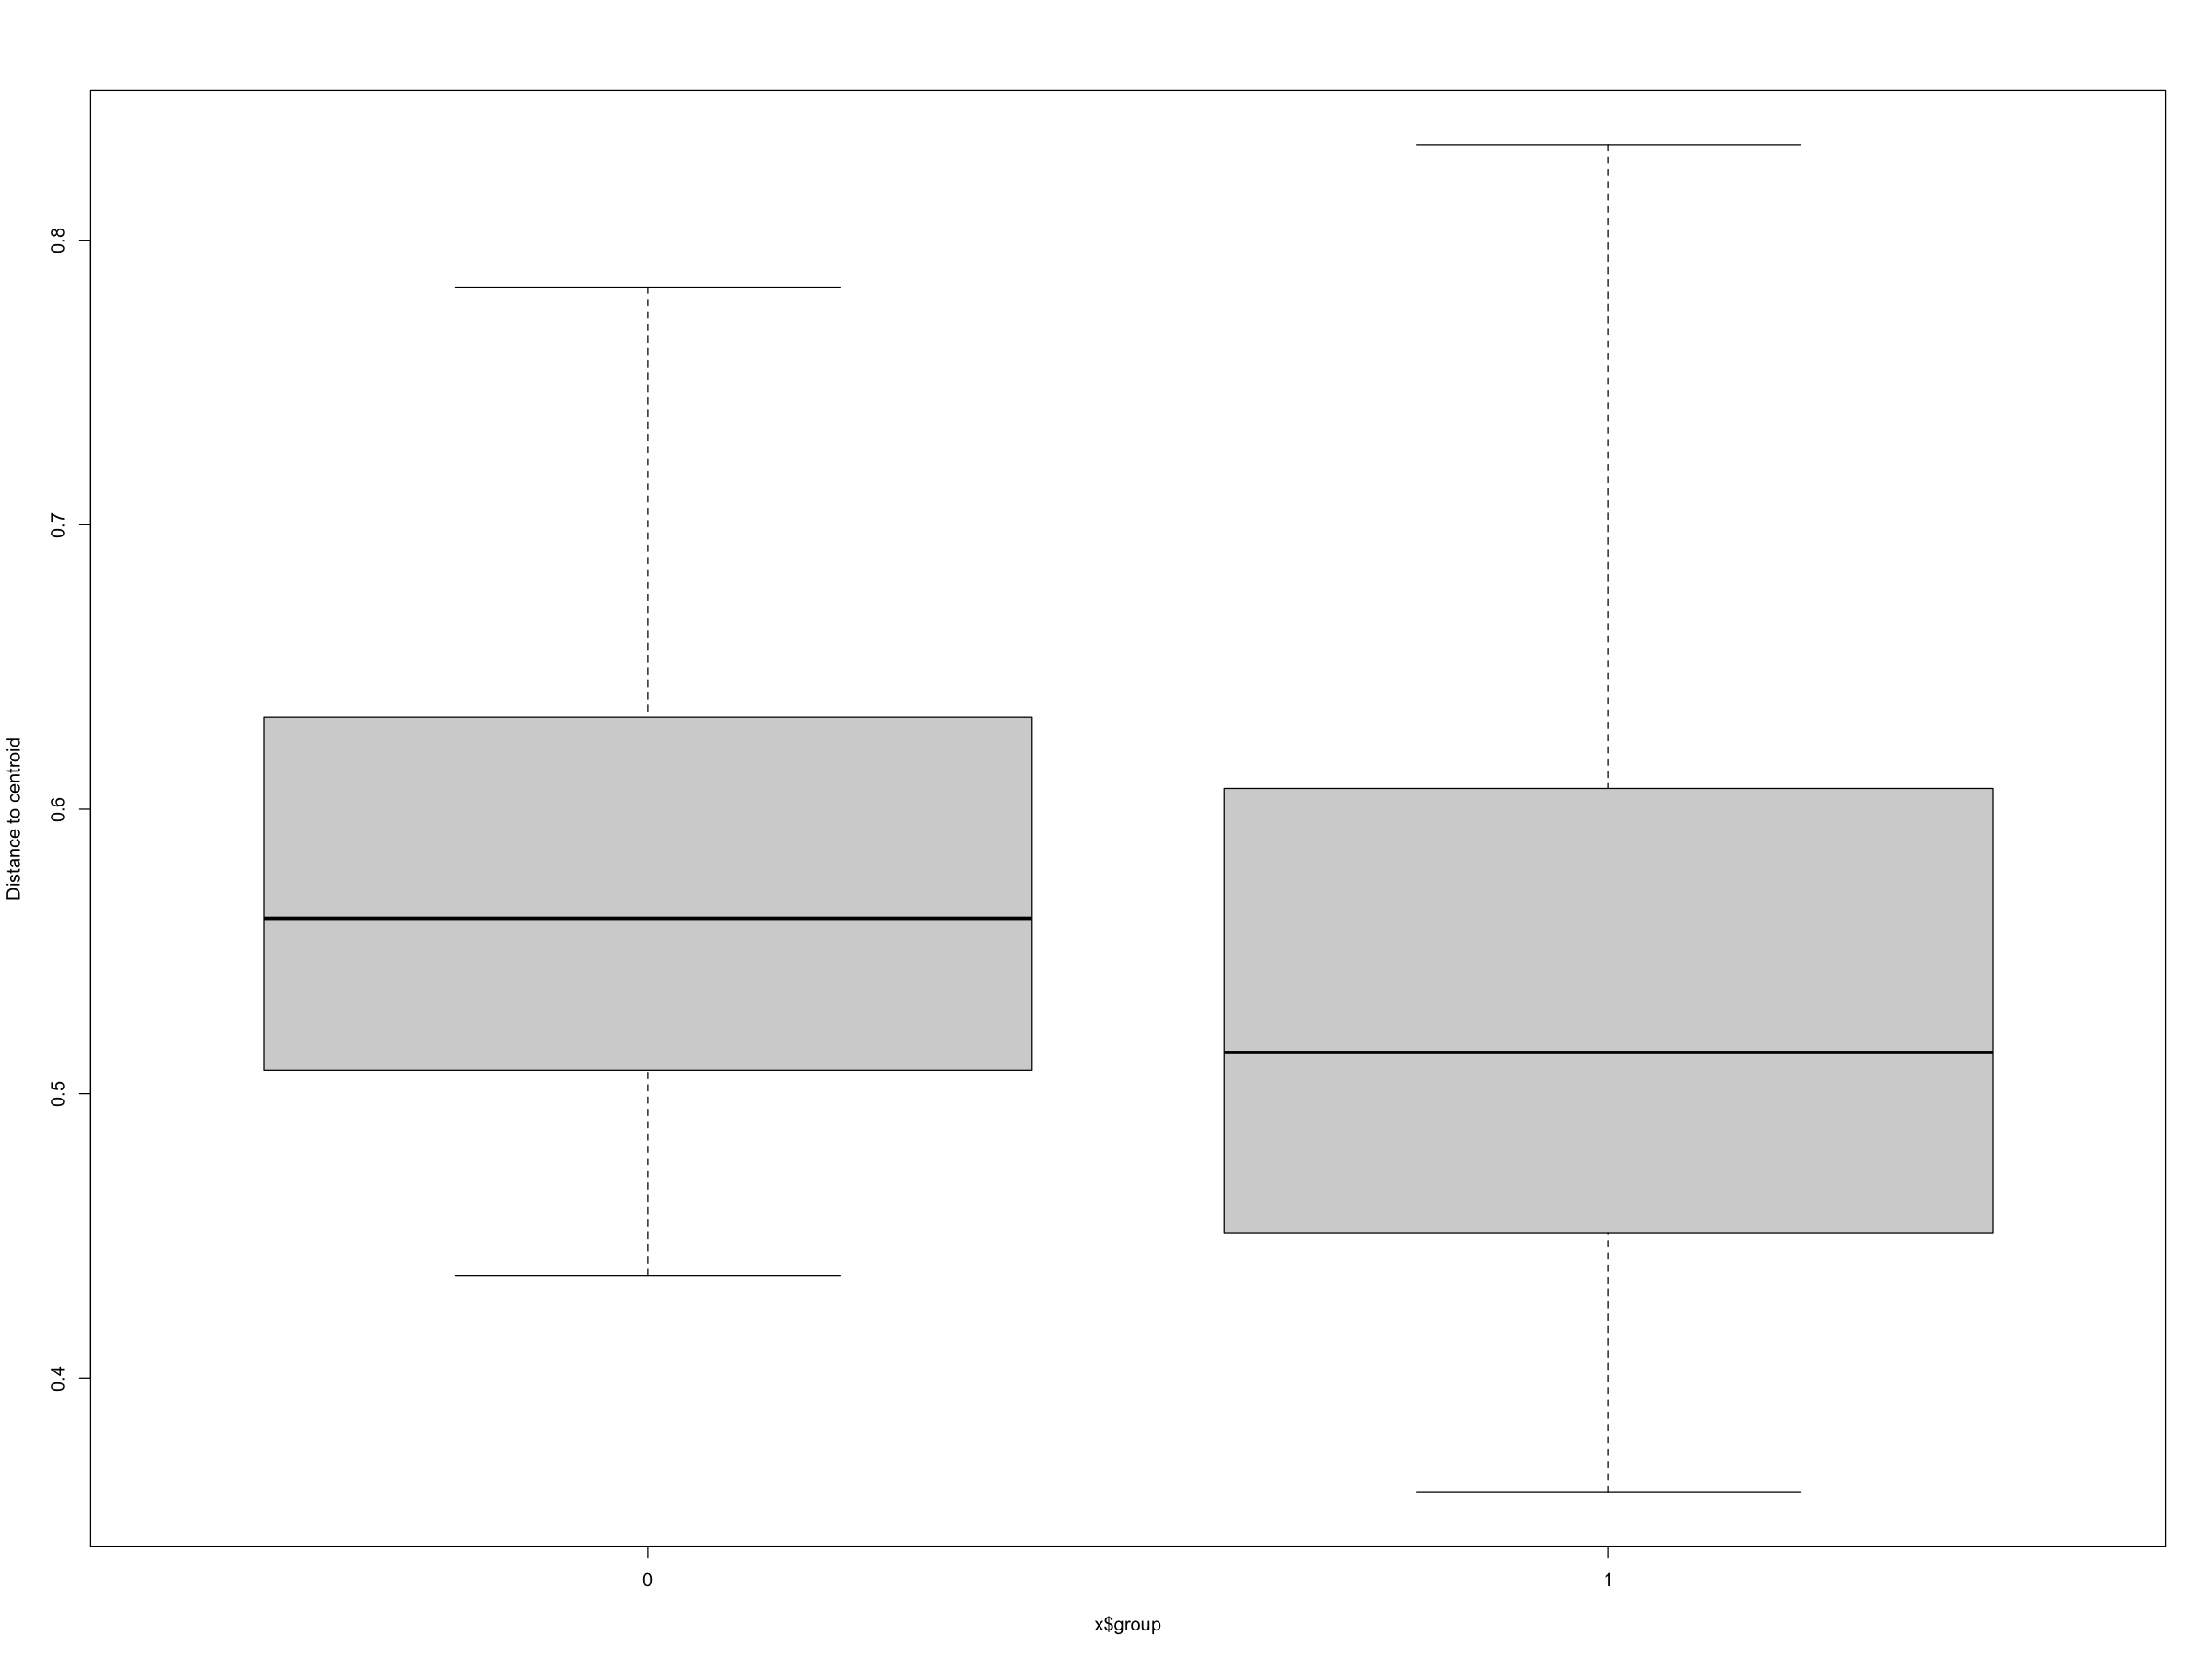

In [101]:
boxplot(bd.RFTM_pa)

In [51]:
bd.Treatment1_Density


	Homogeneity of multivariate dispersions

Call: betadisper(d = DE18CV.dist, group = sampledf$Treatment1_Density)

No. of Positive Eigenvalues: 51
No. of Negative Eigenvalues: 6

Average distance to median:
  HIGH    LOW 
0.5715 0.5052 

Eigenvalues for PCoA axes:
(Showing 8 of 57 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
4.2787 2.0655 1.6253 1.2783 0.9977 0.7210 0.6446 0.5681 

In [52]:
anova(bd.Treatment1_Density)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,1,0.06294805,0.06294805,2.870758,0.09575757
Residuals,56,1.22793041,0.02192733,NA,NA


In [54]:
anova(bd.Treatment2_Diversity)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,1,0.004600282,0.004600282,0.1961752,0.6595323
Residuals,56,1.313192566,0.023449867,NA,NA


In [44]:
permutest(bd.Treatment1_Density)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df  Sum Sq  Mean Sq      F N.Perm Pr(>F)
Groups     1 0.06295 0.062948 2.8708    999  0.111
Residuals 56 1.22793 0.021927                     

In [38]:
distances=as.data.frame(bd.Treatment1_Density$distances)


In [39]:
colnames(distances)="distance_from_centroid"
distances=merge(distances, meta, by.x="row.names", by.y="UniqueID")


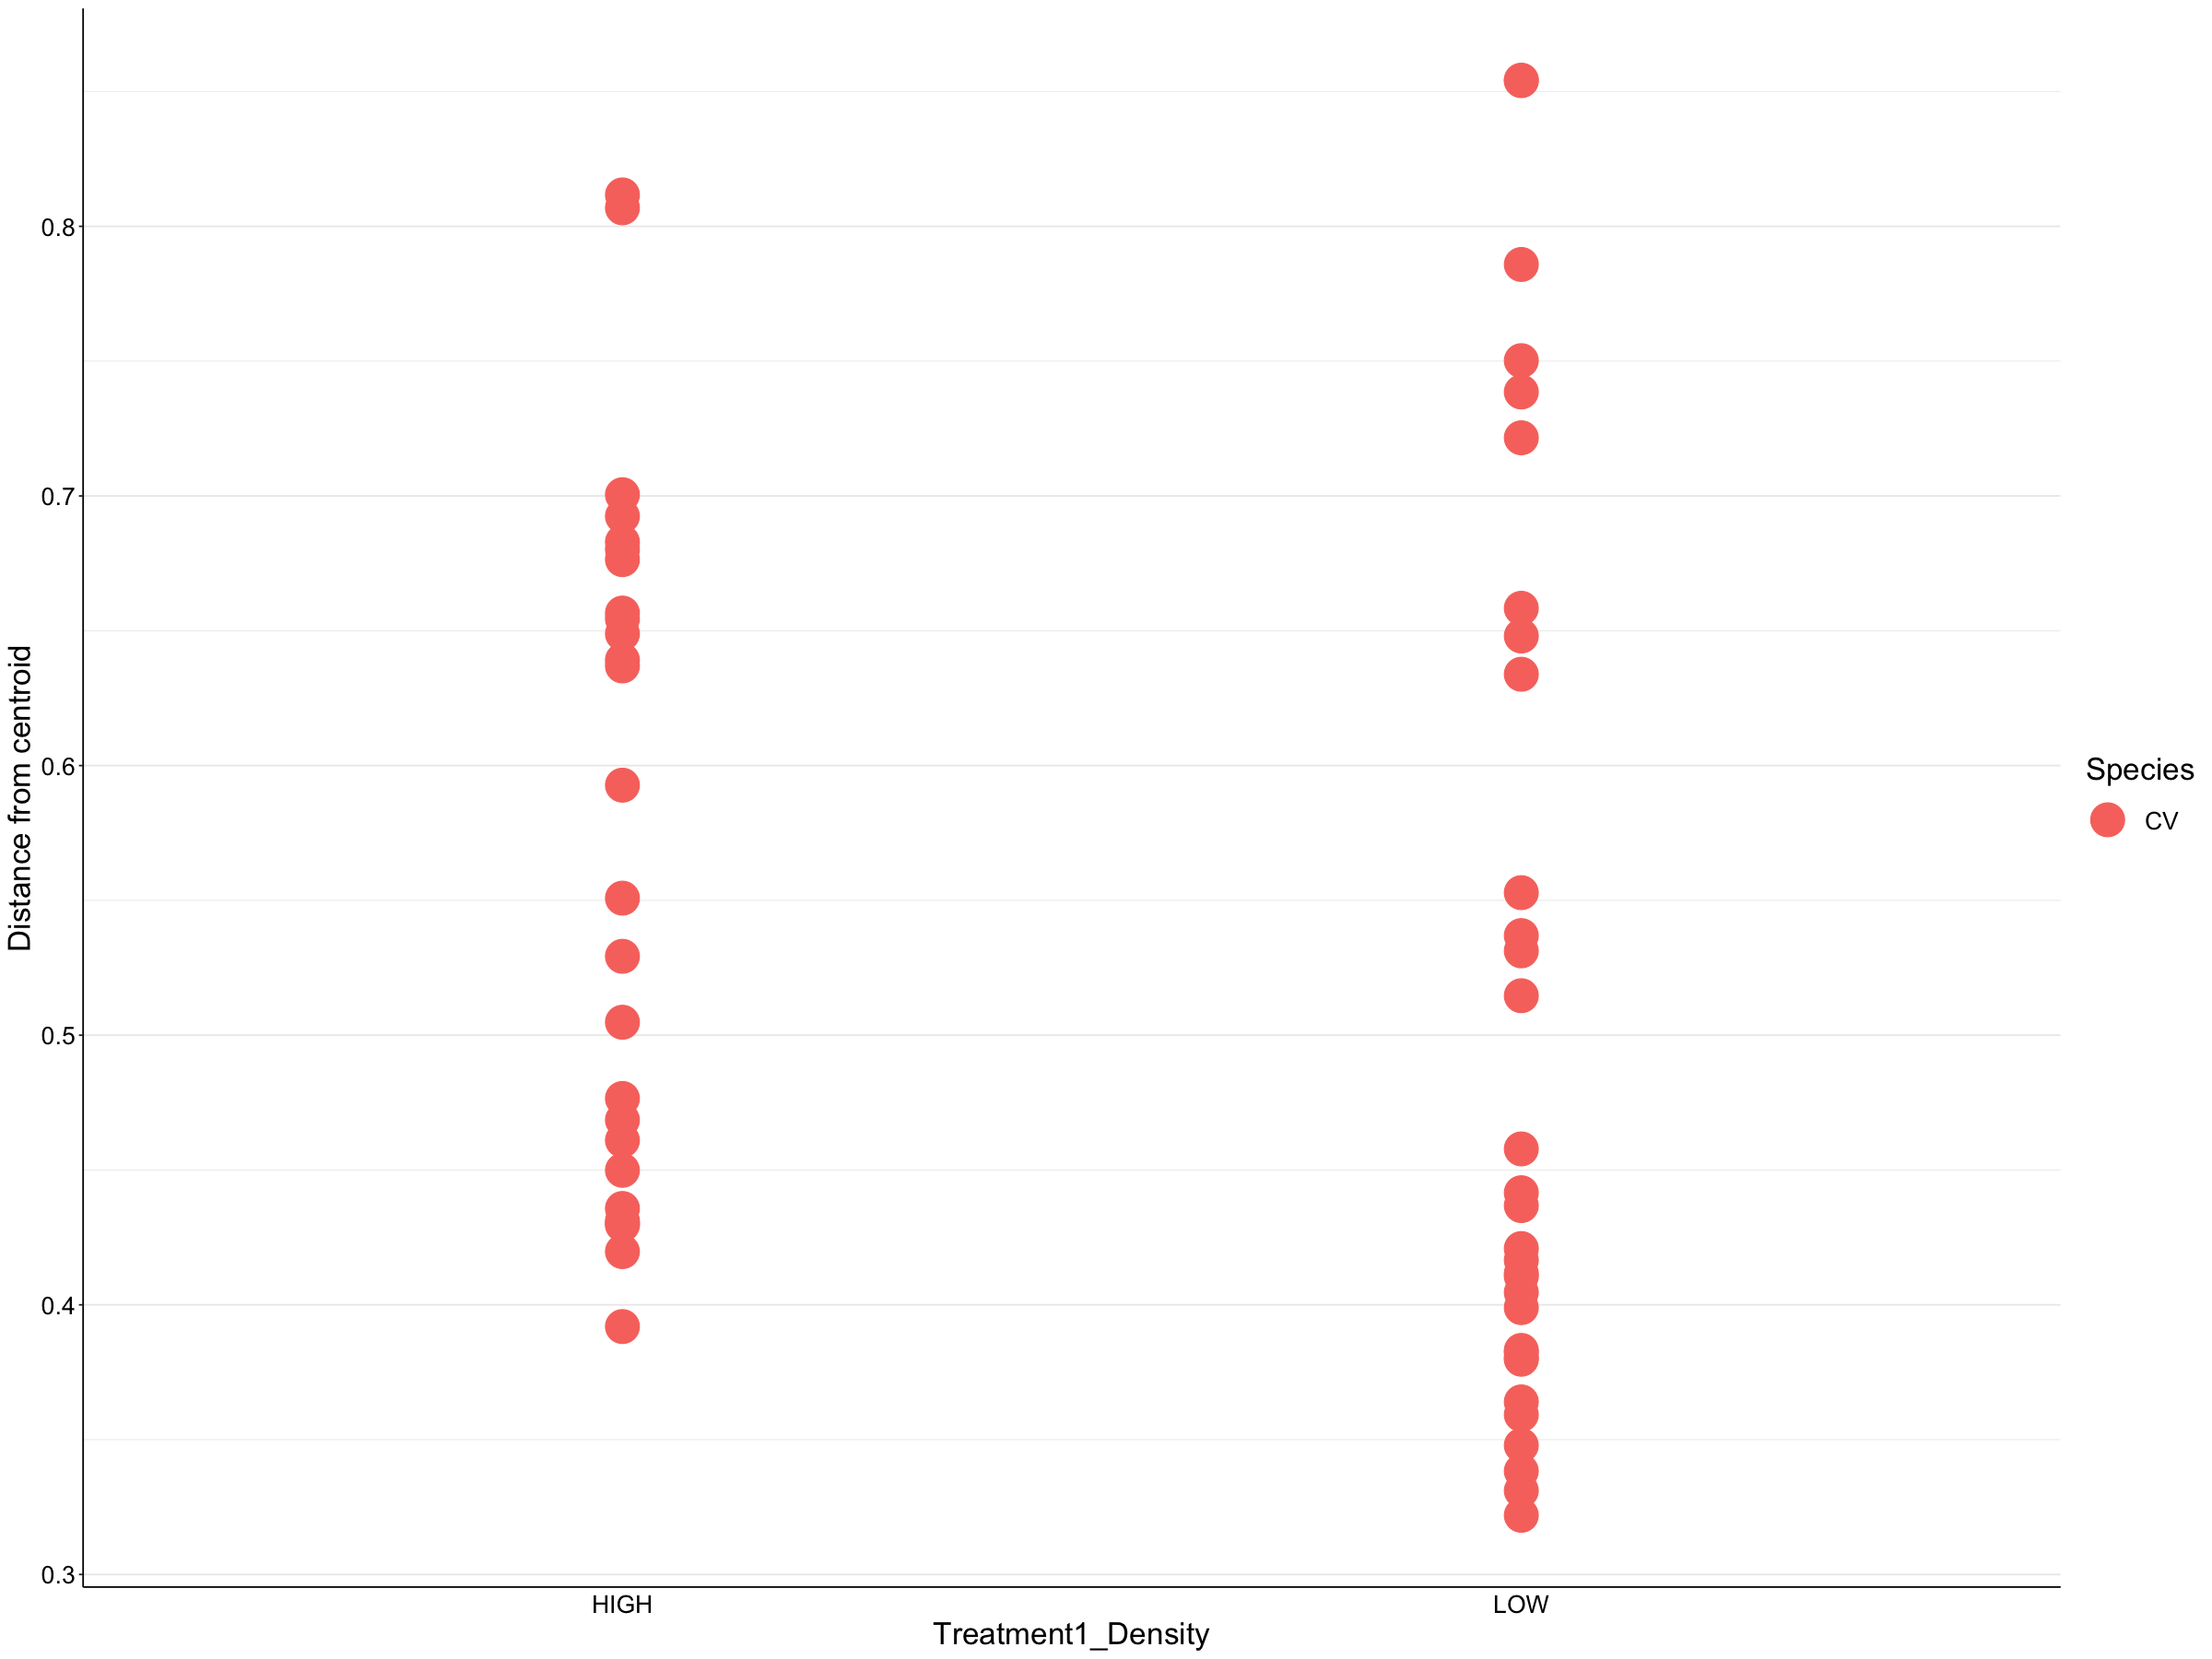

In [40]:
ggplot(distances, aes(y = distance_from_centroid, x = Treatment1_Density, col=Species)) +
       geom_point(size=10)+

theme_bw()+
 
theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
    
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), axis.text=element_text(color="black"),
          text = element_text(size=20))+
ylab("Distance from centroid")


In [24]:
bd.Species


	Homogeneity of multivariate dispersions

Call: betadisper(d = DE18.dist, group = sampledf$Species)

No. of Positive Eigenvalues: 80
No. of Negative Eigenvalues: 19

Average distance to median:
    CV     IR     MB     MM 
0.5492 0.4145 0.4843 0.5888 

Eigenvalues for PCoA axes:
(Showing 8 of 99 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
11.117  4.158  2.138  1.895  1.628  1.134  1.022  1.017 

In [25]:
distances=as.data.frame(bd.Species$distances)


In [50]:
distances

,bd.Bucket$distances
,<dbl>
2018__HIGH_MONO_HM1O73_CV,0.1756692
2018__HIGH_MONO_HM1W15_CV,0.7355004
2018__HIGH_MONO_HM1W33_CV,0.5598616
2018__HIGH_MONO_HM1W96_CV,0.2577098
2018__HIGH_MONO_HM4Y44_CV,0.2165486
2018__HIGH_MONO_HM4Y53_CV,0.2165486
2018__HIGH_MONO_HM8O20_CV,0.6140257
2018__HIGH_MONO_HM8O34_CV,0.4373556
2018__HIGH_MONO_HM8O66_CV,0.4553934


In [26]:
colnames(distances)="distance_from_centroid"


In [27]:
distances=merge(distances, meta, by.x="row.names", by.y="UniqueID")


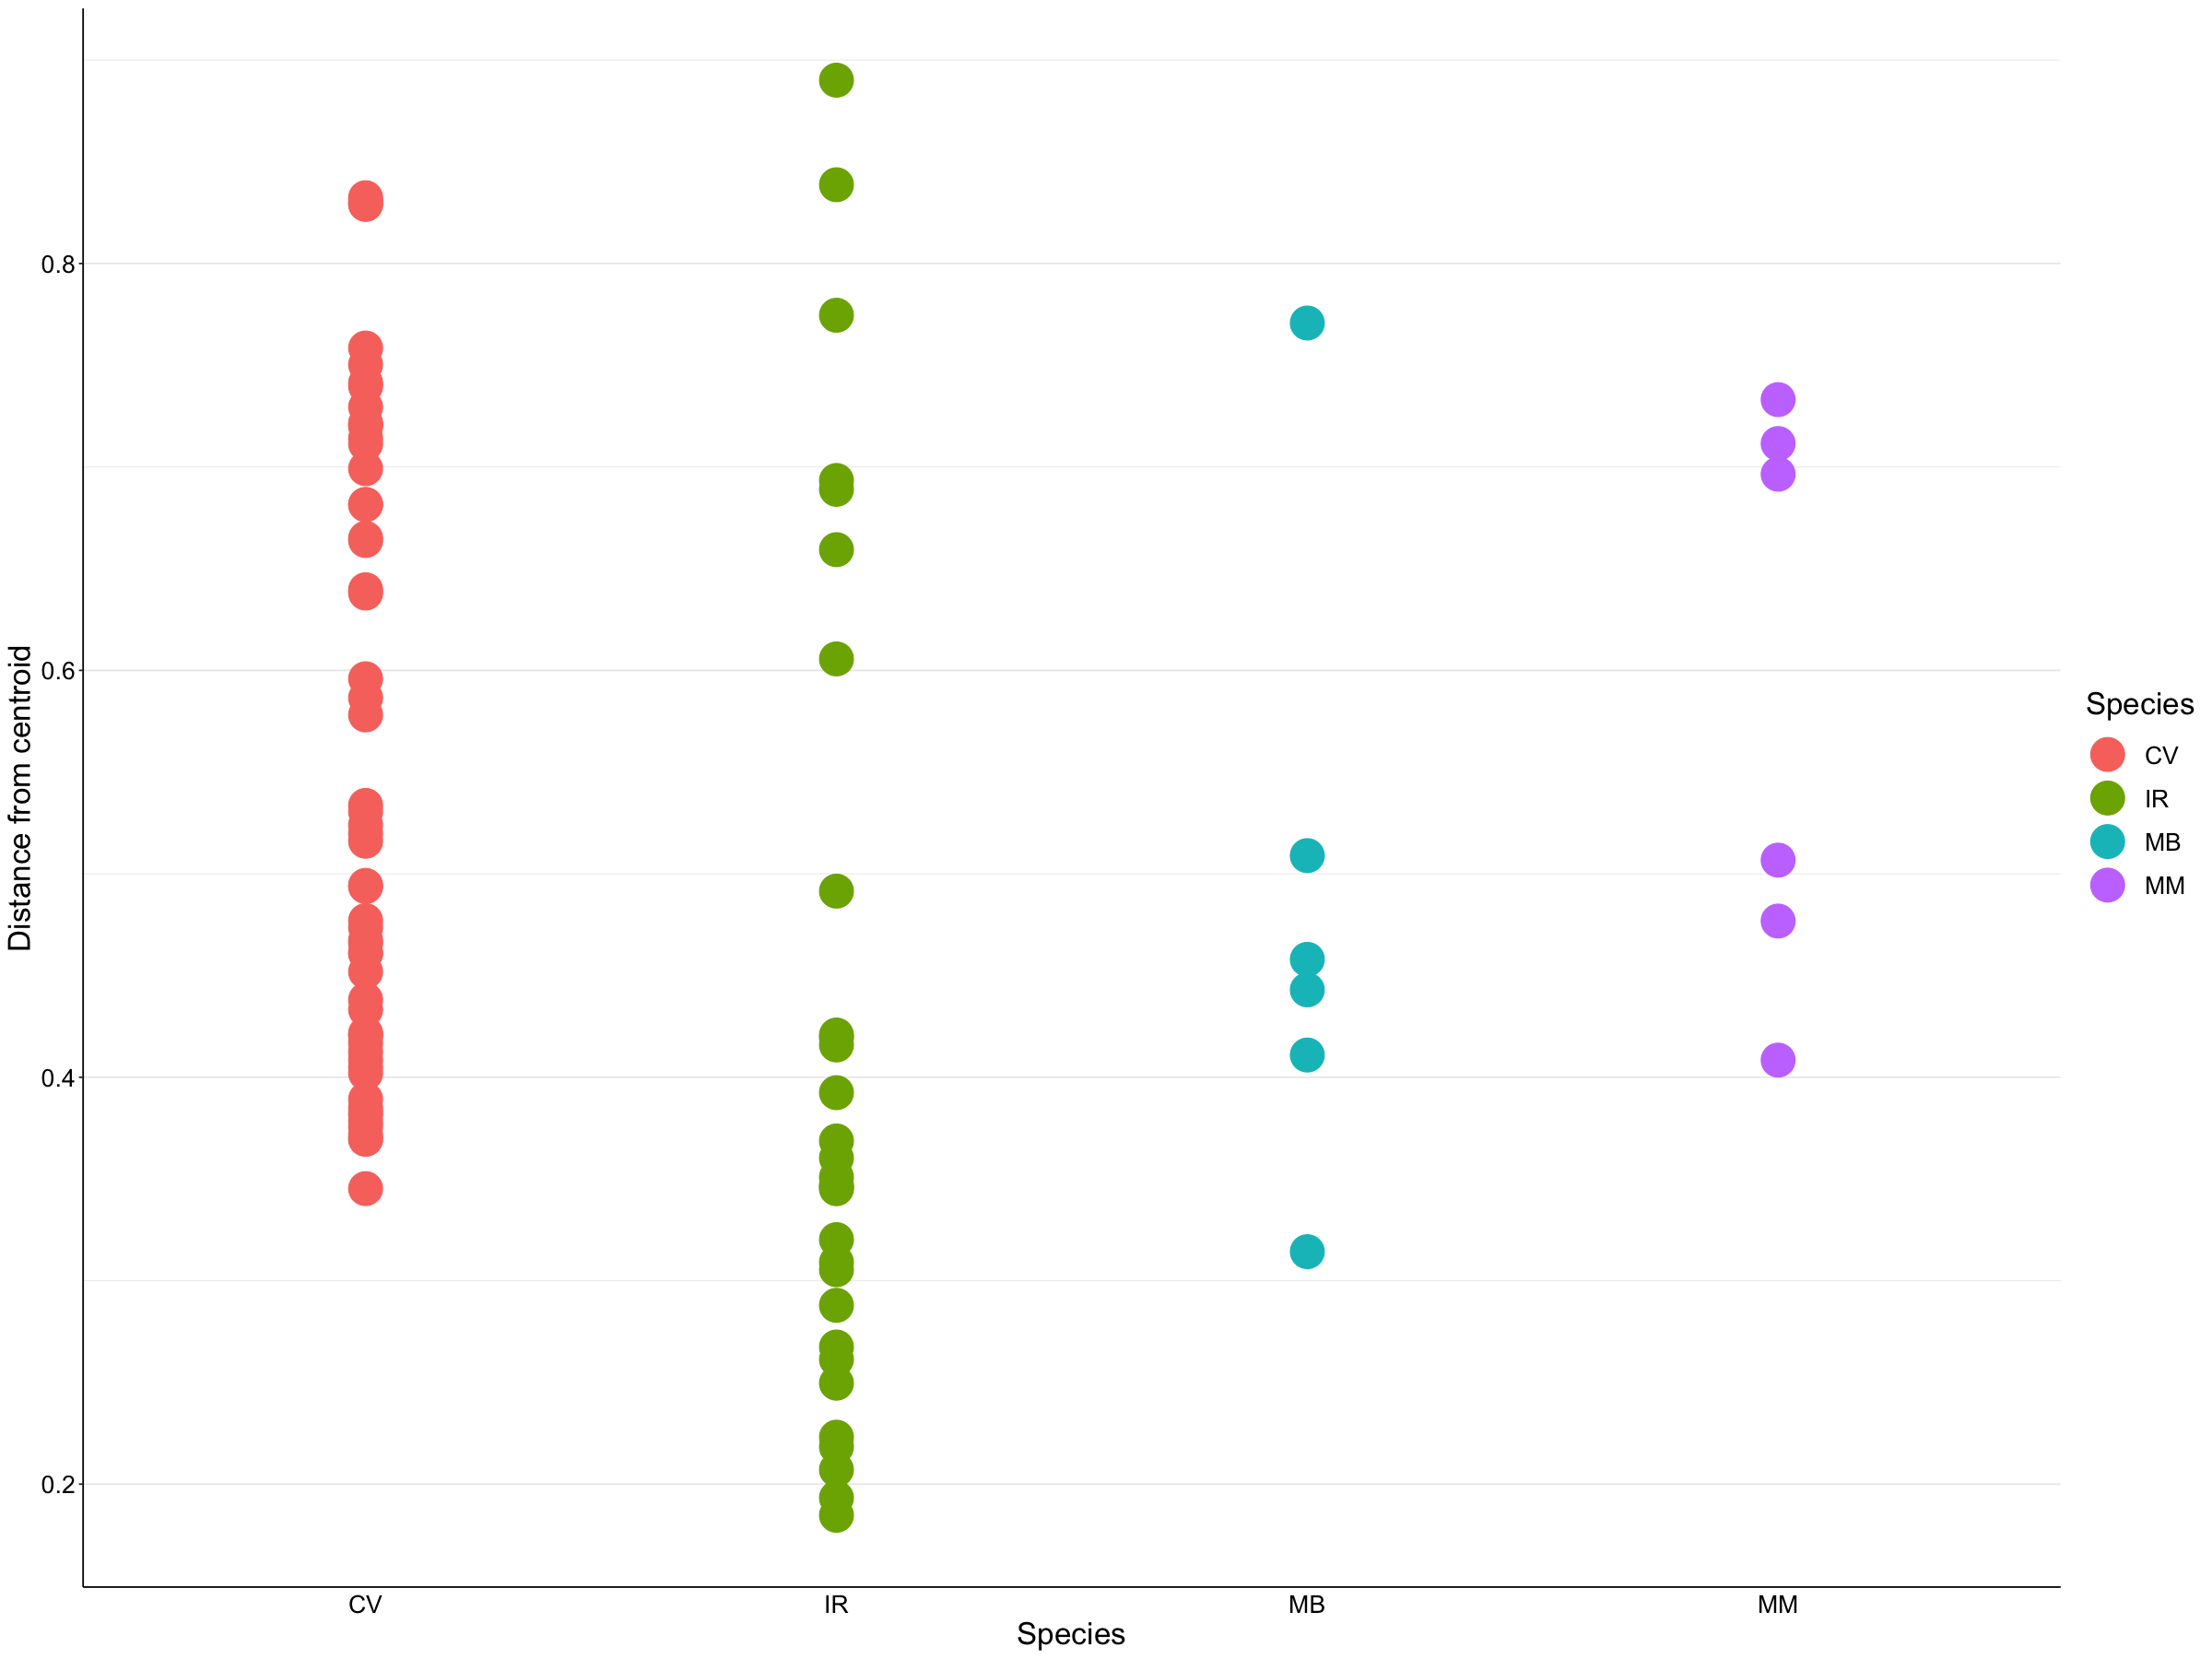

In [64]:
ggplot(distances, aes(y = distance_from_centroid, x = Species, col=Species)) +
       geom_point(size=10)+

theme_bw()+
 
theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
    
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), axis.text=element_text(color="black"),
          text = element_text(size=20))+
ylab("Distance from centroid")
